# Data Wrangling - Billboard Hot 100 & Spotify Track Data

## 1.0 Data Collection

### 1.1 Imports

In [1]:
import pandas as pd
import datetime as datetime
import billboard
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from fuzzywuzzy import fuzz
import os
import matplotlib.pyplot as plt
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### 1.2 Pull Billboard Hot 100 Data

In [2]:
#Pull key Billboard data for x number_of_weeks - includes rank, song, artist, peak position and number of weeks on the list

#Dictate the number of weeks data is required for
number_of_weeks = 87
billboard_data = {}

base = datetime.datetime(2021, 8, 28).date()
dates_list = [str(base - datetime.timedelta(days=x*7)) for x in range(number_of_weeks)]

for date in dates_list:
    chart = billboard.ChartData('hot-100', date=date, fetch=True, timeout=25)

    song_dict = {chart[i].rank: [chart[i].title, chart[i].artist, chart[i].peakPos, chart[i].weeks] for i in range(100)}
    billboard_data[date] = song_dict

chart_data = pd.DataFrame.from_dict(billboard_data)

#chart_data

### 1.3 Clean Billboard Hot 100 DataFrame

In [3]:
chart_data = chart_data.reset_index()
chart_data = chart_data.rename(columns={"index": "Rank"})
chart_data = pd.melt(chart_data, id_vars = ['Rank'], var_name = ['Date'])
chart_data[['BB_Title','BB_Artist','BB_PeakPos','BB_Weeks']] = \
    pd.DataFrame(chart_data['value'].tolist(), index= chart_data.index)
chart_data = chart_data.drop(columns=['value'])

chart_data

,Rank,Date,BB_Title,BB_Artist,BB_PeakPos,BB_Weeks
0,1,2021-08-28,Stay,The Kid LAROI & Justin Bieber,1,6
1,2,2021-08-28,Bad Habits,Ed Sheeran,2,8
2,3,2021-08-28,Good 4 U,Olivia Rodrigo,1,14
3,4,2021-08-28,Rumors,Lizzo Featuring Cardi B,4,1
4,5,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,3,19
...,...,...,...,...,...,...
8695,96,2020-01-04,Candy,Doja Cat,86,5
8696,97,2020-01-04,BEST ON EARTH,Russ & BIA,92,3
8697,98,2020-01-04,Tusa,Karol G & Nicki Minaj,78,4
8698,99,2020-01-04,Enemies,Post Malone Featuring DaBaby,16,16


### 1.4 Isolate Unique Songs From Hot 100 DataFrame

In [4]:
unique_songs = chart_data.drop_duplicates(subset = ['BB_Title', 'BB_Artist'])\
                    .reset_index(drop=True)

unique_songs

,Rank,Date,BB_Title,BB_Artist,BB_PeakPos,BB_Weeks
0,1,2021-08-28,Stay,The Kid LAROI & Justin Bieber,1,6
1,2,2021-08-28,Bad Habits,Ed Sheeran,2,8
2,3,2021-08-28,Good 4 U,Olivia Rodrigo,1,14
3,4,2021-08-28,Rumors,Lizzo Featuring Cardi B,4,1
4,5,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,3,19
...,...,...,...,...,...,...
1195,44,2020-01-04,Like It's Christmas,Jonas Brothers,44,4
1196,45,2020-01-04,Baby It's Cold Outside,Dean Martin,45,1
1197,69,2020-01-04,Happy Xmas (War Is Over),John Legend,69,1
1198,79,2020-01-04,Hate Me,Ellie Goulding & Juice WRLD,56,20


### 1.5 Find Unique Songs in Spotify

In [5]:
cid = '67d7ec42ddd4497887d1d28bcf66d607'
secret = '0ae4cd8474934b0fa2705ce70a47fd3d'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [6]:
#test code for reviewing sp.search outputs
test_search = sp.search(q='track:Happier', type='track', limit=2, market='US')

#test_search

In [7]:
def song_data(title, artist):
    '''Searches Spotify for song title in Billboard Hot 100 list, returns the 
    top 4 searches and finds the highest match ratio between artist. 
    Returns highest match ratio title, artist and song id'''
    
    song = []
    highest_ratio = 0
    track_results = sp.search(q='track:'+title, type='track', limit=4, market='US')
    
    for i, t in enumerate(track_results['tracks']['items']):
        match_ratio = fuzz.partial_ratio(artist, t['artists'][0]['name'])
        if match_ratio > highest_ratio:
            highest_ratio = match_ratio
            song = []
            song.append(t['name'])
            song.append(t['artists'][0]['name'])
            song.append(highest_ratio)
            song.append(t['id'])
    return song

In [8]:
unique_songs['SP_Data'] = unique_songs.apply(lambda row: song_data(row['BB_Title'],row['BB_Artist']),axis=1)

unique_songs[['SP_Title','SP_Artist','Match_Ratio','SP_id']] = pd.DataFrame(unique_songs.SP_Data.tolist(), \
                                                                            index= unique_songs.index)

unique_songs = unique_songs.drop(columns=['SP_Data'])

unique_songs

,Rank,Date,BB_Title,BB_Artist,BB_PeakPos,BB_Weeks,SP_Title,SP_Artist,Match_Ratio,SP_id
0,1,2021-08-28,Stay,The Kid LAROI & Justin Bieber,1,6,STAY (with Justin Bieber),The Kid LAROI,100.0,5HCyWlXZPP0y6Gqq8TgA20
1,2,2021-08-28,Bad Habits,Ed Sheeran,2,8,Bad Habits,Ed Sheeran,100.0,6PQ88X9TkUIAUIZJHW2upE
2,3,2021-08-28,Good 4 U,Olivia Rodrigo,1,14,good 4 u,Olivia Rodrigo,100.0,4ZtFanR9U6ndgddUvNcjcG
3,4,2021-08-28,Rumors,Lizzo Featuring Cardi B,4,1,Rumors (feat. Cardi B),Lizzo,100.0,6KgtcmCF9Ky68XC7ezxl3s
4,5,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,3,19,Kiss Me More (feat. SZA),Doja Cat,100.0,748mdHapucXQri7IAO8yFK
...,...,...,...,...,...,...,...,...,...,...
1195,44,2020-01-04,Like It's Christmas,Jonas Brothers,44,4,Like It's Christmas,Jonas Brothers,100.0,1OjmlSFuzYflWjSMTCyTJv
1196,45,2020-01-04,Baby It's Cold Outside,Dean Martin,45,1,Santa Baby,Kylie Minogue,48.0,1uNeZXePO5jPleqY64RGSy
1197,69,2020-01-04,Happy Xmas (War Is Over),John Legend,69,1,Happy Xmas (War Is Over) - Remastered 2010,John Lennon,73.0,27RYrbL6S02LNVhDWVl38b
1198,79,2020-01-04,Hate Me,Ellie Goulding & Juice WRLD,56,20,Hate Me (with Juice WRLD),Ellie Goulding,100.0,6kls8cSlUyHW2BUOkDJIZE


### 1.6 Get Song Attributes from Spotify

In [9]:
def song_atts(sp_id):
    '''Uses SP_id to find Spotify song attributes''' 
    song_attributes = {}
    
    if sp_id != None:
        att_results = sp.audio_features(tracks=sp_id)
        song_attributes = att_results[0] 
    return song_attributes

In [10]:
unique_songs['SP_Atts'] = unique_songs.apply(lambda row: song_atts(row['SP_id']),axis=1)

unique_songs = pd.concat([unique_songs.drop(['SP_Atts'], axis=1), unique_songs['SP_Atts'].apply(pd.Series)], axis=1)
unique_songs = unique_songs.drop(['type','id','uri'], axis=1)

unique_songs

,Rank,Date,BB_Title,BB_Artist,BB_PeakPos,BB_Weeks,SP_Title,SP_Artist,Match_Ratio,SP_id,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_href,analysis_url,duration_ms,time_signature
0,1,2021-08-28,Stay,The Kid LAROI & Justin Bieber,1,6,STAY (with Justin Bieber),The Kid LAROI,100.0,5HCyWlXZPP0y6Gqq8TgA20,...,0.0483,0.0383,0.000000,0.1030,0.478,169.928,https://api.spotify.com/v1/tracks/5HCyWlXZPP0y...,https://api.spotify.com/v1/audio-analysis/5HCy...,141806.0,4.0
1,2,2021-08-28,Bad Habits,Ed Sheeran,2,8,Bad Habits,Ed Sheeran,100.0,6PQ88X9TkUIAUIZJHW2upE,...,0.0348,0.0469,0.000031,0.3640,0.591,126.026,https://api.spotify.com/v1/tracks/6PQ88X9TkUIA...,https://api.spotify.com/v1/audio-analysis/6PQ8...,231041.0,4.0
2,3,2021-08-28,Good 4 U,Olivia Rodrigo,1,14,good 4 u,Olivia Rodrigo,100.0,4ZtFanR9U6ndgddUvNcjcG,...,0.1540,0.3350,0.000000,0.0849,0.688,166.928,https://api.spotify.com/v1/tracks/4ZtFanR9U6nd...,https://api.spotify.com/v1/audio-analysis/4ZtF...,178147.0,4.0
3,4,2021-08-28,Rumors,Lizzo Featuring Cardi B,4,1,Rumors (feat. Cardi B),Lizzo,100.0,6KgtcmCF9Ky68XC7ezxl3s,...,0.0880,0.1300,0.000000,0.4180,0.607,118.992,https://api.spotify.com/v1/tracks/6KgtcmCF9Ky6...,https://api.spotify.com/v1/audio-analysis/6Kgt...,172833.0,4.0
4,5,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,3,19,Kiss Me More (feat. SZA),Doja Cat,100.0,748mdHapucXQri7IAO8yFK,...,0.0286,0.2350,0.000158,0.1230,0.742,110.968,https://api.spotify.com/v1/tracks/748mdHapucXQ...,https://api.spotify.com/v1/audio-analysis/748m...,208867.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,44,2020-01-04,Like It's Christmas,Jonas Brothers,44,4,Like It's Christmas,Jonas Brothers,100.0,1OjmlSFuzYflWjSMTCyTJv,...,0.1020,0.0183,0.000000,0.0519,0.610,146.035,https://api.spotify.com/v1/tracks/1OjmlSFuzYfl...,https://api.spotify.com/v1/audio-analysis/1Ojm...,200880.0,4.0
1196,45,2020-01-04,Baby It's Cold Outside,Dean Martin,45,1,Santa Baby,Kylie Minogue,48.0,1uNeZXePO5jPleqY64RGSy,...,0.0435,0.7440,0.000000,0.1420,0.443,87.101,https://api.spotify.com/v1/tracks/1uNeZXePO5jP...,https://api.spotify.com/v1/audio-analysis/1uNe...,202547.0,4.0
1197,69,2020-01-04,Happy Xmas (War Is Over),John Legend,69,1,Happy Xmas (War Is Over) - Remastered 2010,John Lennon,73.0,27RYrbL6S02LNVhDWVl38b,...,0.0324,0.2800,0.000000,0.7180,0.414,146.172,https://api.spotify.com/v1/tracks/27RYrbL6S02L...,https://api.spotify.com/v1/audio-analysis/27RY...,214333.0,3.0
1198,79,2020-01-04,Hate Me,Ellie Goulding & Juice WRLD,56,20,Hate Me (with Juice WRLD),Ellie Goulding,100.0,6kls8cSlUyHW2BUOkDJIZE,...,0.0507,0.1080,0.000000,0.1440,0.759,75.025,https://api.spotify.com/v1/tracks/6kls8cSlUyHW...,https://api.spotify.com/v1/audio-analysis/6kls...,186223.0,4.0


### 1.7 Export Complete Data to CSV

In [11]:
#Export unique song data.

#cwd = os.getcwd()
#path = cwd + "/new"
#unique_songs.to_csv(path)

## 2.0 Initial Data Exploration

### 2.1 Data Types

In [12]:
unique_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rank              1200 non-null   int64  
 1   Date              1200 non-null   object 
 2   BB_Title          1200 non-null   object 
 3   BB_Artist         1200 non-null   object 
 4   BB_PeakPos        1200 non-null   int64  
 5   BB_Weeks          1200 non-null   int64  
 6   SP_Title          1191 non-null   object 
 7   SP_Artist         1191 non-null   object 
 8   Match_Ratio       1191 non-null   float64
 9   SP_id             1191 non-null   object 
 10  danceability      1191 non-null   float64
 11  energy            1191 non-null   float64
 12  key               1191 non-null   float64
 13  loudness          1191 non-null   float64
 14  mode              1191 non-null   float64
 15  speechiness       1191 non-null   float64
 16  acousticness      1191 non-null   float64


In [13]:
unique_songs.head()

,Rank,Date,BB_Title,BB_Artist,BB_PeakPos,BB_Weeks,SP_Title,SP_Artist,Match_Ratio,SP_id,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_href,analysis_url,duration_ms,time_signature
0,1,2021-08-28,Stay,The Kid LAROI & Justin Bieber,1,6,STAY (with Justin Bieber),The Kid LAROI,100.0,5HCyWlXZPP0y6Gqq8TgA20,...,0.0483,0.0383,0.000000,0.1030,0.478,169.928,https://api.spotify.com/v1/tracks/5HCyWlXZPP0y...,https://api.spotify.com/v1/audio-analysis/5HCy...,141806.0,4.0
1,2,2021-08-28,Bad Habits,Ed Sheeran,2,8,Bad Habits,Ed Sheeran,100.0,6PQ88X9TkUIAUIZJHW2upE,...,0.0348,0.0469,0.000031,0.3640,0.591,126.026,https://api.spotify.com/v1/tracks/6PQ88X9TkUIA...,https://api.spotify.com/v1/audio-analysis/6PQ8...,231041.0,4.0
2,3,2021-08-28,Good 4 U,Olivia Rodrigo,1,14,good 4 u,Olivia Rodrigo,100.0,4ZtFanR9U6ndgddUvNcjcG,...,0.1540,0.3350,0.000000,0.0849,0.688,166.928,https://api.spotify.com/v1/tracks/4ZtFanR9U6nd...,https://api.spotify.com/v1/audio-analysis/4ZtF...,178147.0,4.0
3,4,2021-08-28,Rumors,Lizzo Featuring Cardi B,4,1,Rumors (feat. Cardi B),Lizzo,100.0,6KgtcmCF9Ky68XC7ezxl3s,...,0.0880,0.1300,0.000000,0.4180,0.607,118.992,https://api.spotify.com/v1/tracks/6KgtcmCF9Ky6...,https://api.spotify.com/v1/audio-analysis/6Kgt...,172833.0,4.0
4,5,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,3,19,Kiss Me More (feat. SZA),Doja Cat,100.0,748mdHapucXQri7IAO8yFK,...,0.0286,0.2350,0.000158,0.1230,0.742,110.968,https://api.spotify.com/v1/tracks/748mdHapucXQ...,https://api.spotify.com/v1/audio-analysis/748m...,208867.0,4.0


In [14]:
unique_songs[unique_songs.SP_Title == 'Bad Habits'].transpose()

,1,1079
Rank,2,59
Date,2021-08-28,2020-03-07
BB_Title,Bad Habits,Bad Bad
BB_Artist,Ed Sheeran,YoungBoy Never Broke Again
BB_PeakPos,2,59
BB_Weeks,8,1
SP_Title,Bad Habits,Bad Habits
SP_Artist,Ed Sheeran,Ed Sheeran
Match_Ratio,100.0,40.0
SP_id,6PQ88X9TkUIAUIZJHW2upE,6PQ88X9TkUIAUIZJHW2upE


### 2.2 Categorical Data

In [15]:
unique_songs.select_dtypes('object')

,Date,BB_Title,BB_Artist,SP_Title,SP_Artist,SP_id,track_href,analysis_url
0,2021-08-28,Stay,The Kid LAROI & Justin Bieber,STAY (with Justin Bieber),The Kid LAROI,5HCyWlXZPP0y6Gqq8TgA20,https://api.spotify.com/v1/tracks/5HCyWlXZPP0y...,https://api.spotify.com/v1/audio-analysis/5HCy...
1,2021-08-28,Bad Habits,Ed Sheeran,Bad Habits,Ed Sheeran,6PQ88X9TkUIAUIZJHW2upE,https://api.spotify.com/v1/tracks/6PQ88X9TkUIA...,https://api.spotify.com/v1/audio-analysis/6PQ8...
2,2021-08-28,Good 4 U,Olivia Rodrigo,good 4 u,Olivia Rodrigo,4ZtFanR9U6ndgddUvNcjcG,https://api.spotify.com/v1/tracks/4ZtFanR9U6nd...,https://api.spotify.com/v1/audio-analysis/4ZtF...
3,2021-08-28,Rumors,Lizzo Featuring Cardi B,Rumors (feat. Cardi B),Lizzo,6KgtcmCF9Ky68XC7ezxl3s,https://api.spotify.com/v1/tracks/6KgtcmCF9Ky6...,https://api.spotify.com/v1/audio-analysis/6Kgt...
4,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,Kiss Me More (feat. SZA),Doja Cat,748mdHapucXQri7IAO8yFK,https://api.spotify.com/v1/tracks/748mdHapucXQ...,https://api.spotify.com/v1/audio-analysis/748m...
...,...,...,...,...,...,...,...,...
1195,2020-01-04,Like It's Christmas,Jonas Brothers,Like It's Christmas,Jonas Brothers,1OjmlSFuzYflWjSMTCyTJv,https://api.spotify.com/v1/tracks/1OjmlSFuzYfl...,https://api.spotify.com/v1/audio-analysis/1Ojm...
1196,2020-01-04,Baby It's Cold Outside,Dean Martin,Santa Baby,Kylie Minogue,1uNeZXePO5jPleqY64RGSy,https://api.spotify.com/v1/tracks/1uNeZXePO5jP...,https://api.spotify.com/v1/audio-analysis/1uNe...
1197,2020-01-04,Happy Xmas (War Is Over),John Legend,Happy Xmas (War Is Over) - Remastered 2010,John Lennon,27RYrbL6S02LNVhDWVl38b,https://api.spotify.com/v1/tracks/27RYrbL6S02L...,https://api.spotify.com/v1/audio-analysis/27RY...
1198,2020-01-04,Hate Me,Ellie Goulding & Juice WRLD,Hate Me (with Juice WRLD),Ellie Goulding,6kls8cSlUyHW2BUOkDJIZE,https://api.spotify.com/v1/tracks/6kls8cSlUyHW...,https://api.spotify.com/v1/audio-analysis/6kls...


In [16]:
unique_songs['BB_Title'].value_counts()

Circles          3
Stay             2
Forever          2
Diamonds         2
Toxic            2
                ..
Wishing Well     1
I Dare You       1
Memories         1
Getting Older    1
Caramelo         1
Name: BB_Title, Length: 1180, dtype: int64

In [17]:
unique_songs['SP_Title'].value_counts()

Circles                                  3
Diamonds Dancing (feat. Travis Scott)    2
You Right                                2
Chicago Freestyle (feat. Giveon)         2
Bad Habits                               2
                                        ..
Woah                                     1
I Can See                                1
Getting Older                            1
Habitual                                 1
Caramelo                                 1
Name: SP_Title, Length: 1166, dtype: int64

In [18]:
unique_songs['BB_Artist'].value_counts()

Taylor Swift                            37
Rod Wave                                25
Lil Uzi Vert                            24
YoungBoy Never Broke Again              21
Morgan Wallen                           18
                                        ..
Lil Baby & Moneybagg Yo                  1
Pooh Shiesty Featuring 21 Savage         1
Bing Crosby & The Andrews Sisters        1
Erica Banks                              1
Megan Thee Stallion Featuring DaBaby     1
Name: BB_Artist, Length: 686, dtype: int64

In [19]:
unique_songs['SP_Artist'].value_counts()

Taylor Swift       38
Lil Baby           35
Lil Uzi Vert       33
Pop Smoke          27
Juice WRLD         25
                   ..
The Fray            1
The Wallflowers     1
All Time Low        1
WizKid              1
Quality Control     1
Name: SP_Artist, Length: 390, dtype: int64

In [20]:
unique_songs['SP_id'].value_counts()

6gBFPUFcJLzWGx4lenP6h2    2
6LcX2hBbXaJcK4AuefE936    2
7uZqvqXzzYMKrexKxdcGmd    2
6potEImiklXkwD9qFzpu15    2
46pF1zFimM582ss1PrMy68    2
                         ..
08Uu8bkE5fuHbjhnZFsyoz    1
0pJalGEYsRikSogLkXU6KV    1
1whfVLMKWqAX3uk97VXsNN    1
2PI3qpTqYowwMzOSQRuj73    1
0jWm0VyD8p3MrSInczpows    1
Name: SP_id, Length: 1172, dtype: int64

In [21]:
unique_songs['Date'].value_counts()

2021-08-28    100
2021-01-02     33
2020-03-14     21
2021-05-22     21
2020-03-07     21
             ... 
2021-02-27      7
2021-03-06      6
2020-01-04      6
2020-06-27      6
2021-01-30      5
Name: Date, Length: 87, dtype: int64

### 2.3 Numeric Data

In [22]:
unique_songs.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rank,1200.0,71.629167,23.068054,1.000000,54.00000,78.0000,91.000000,100.000
BB_PeakPos,1200.0,49.786667,29.217133,1.000000,24.00000,51.5000,74.000000,100.000
BB_Weeks,1200.0,8.545000,11.029779,1.000000,1.00000,2.0000,14.000000,89.000
Match_Ratio,1191.0,92.492024,20.267988,14.000000,100.00000,100.0000,100.000000,100.000
danceability,1191.0,0.674275,0.151822,0.120000,0.57250,0.6890,0.787000,0.965
energy,1191.0,0.621657,0.159234,0.006590,0.52550,0.6330,0.731500,0.984
key,1191.0,5.130982,3.640293,0.000000,1.00000,5.0000,8.000000,11.000
loudness,1191.0,-6.715501,2.573155,-30.415000,-7.79500,-6.3600,-5.062500,-1.786
mode,1191.0,0.599496,0.490206,0.000000,0.00000,1.0000,1.000000,1.000
speechiness,1191.0,0.146866,0.129275,0.023600,0.04390,0.0875,0.226500,0.699


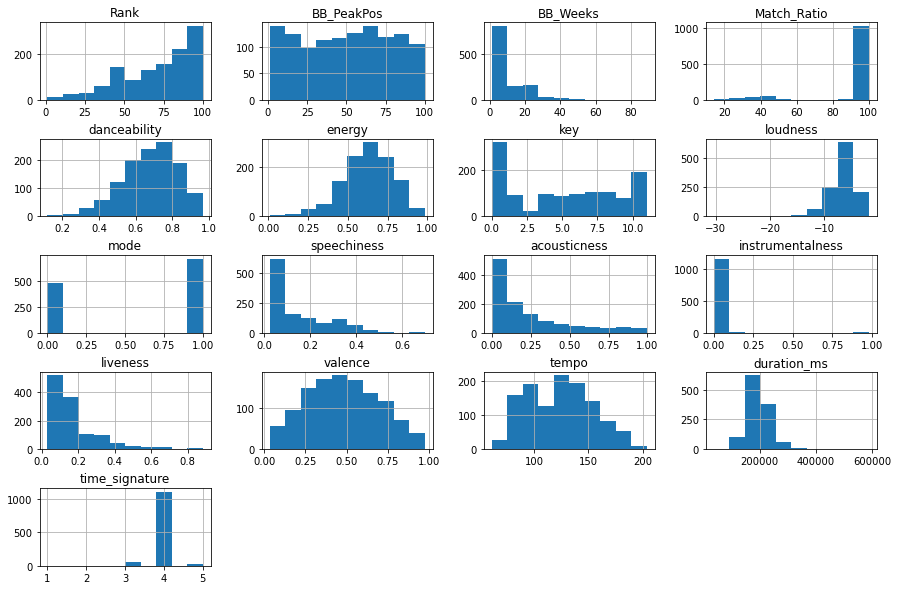

In [23]:
unique_songs.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

### 2.4 Highlighting Risk Areas

In [24]:
#Highlight songs where the match between the Billboard naming and Spotify naming may have pulled the wrong song.
unique_songs[unique_songs.Match_Ratio <= 80].sort_values('Match_Ratio')

,Rank,Date,BB_Title,BB_Artist,BB_PeakPos,BB_Weeks,SP_Title,SP_Artist,Match_Ratio,SP_id,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_href,analysis_url,duration_ms,time_signature
246,72,2021-06-05,applying.pressure,J. Cole,13,2,Applying.Pressure (Remix),Louis Amisi,14.0,2S4T22lQ9xW0Rtoj0XFGDy,...,0.2890,0.087500,0.000000,0.1630,0.466,83.990,https://api.spotify.com/v1/tracks/2S4T22lQ9xW0...,https://api.spotify.com/v1/audio-analysis/2S4T...,178286.0,4.0
524,52,2020-12-26,Happiness,Taylor Swift,52,1,Pursuit Of Happiness (Nightmare),Kid Cudi,17.0,5iSEsR6NKjlC9SrIJkyL3k,...,0.0414,0.484000,0.000093,0.2980,0.266,115.277,https://api.spotify.com/v1/tracks/5iSEsR6NKjlC...,https://api.spotify.com/v1/audio-analysis/5iSE...,295293.0,4.0
954,63,2020-05-02,CAN'T STOP,DaBaby,63,1,Can’t Stop,OneRepublic,17.0,62EsBz11VlUwSu3jFy7Rlo,...,0.0300,0.113000,0.000427,0.1140,0.270,89.994,https://api.spotify.com/v1/tracks/62EsBz11VlUw...,https://api.spotify.com/v1/audio-analysis/62Es...,249573.0,4.0
500,32,2021-01-02,"You're A Mean One, Mr. Grinch",Thurl Ravenscroft,32,2,"You’re A Mean One, Mr. Grinch",Lindsey Stirling,19.0,6TXAjof8V0Gr4zFoY00zHR,...,0.0559,0.134000,0.000000,0.1770,0.424,107.934,https://api.spotify.com/v1/tracks/6TXAjof8V0Gr...,https://api.spotify.com/v1/audio-analysis/6TXA...,166133.0,4.0
773,95,2020-08-08,Perfect,Logic,95,1,She Looks So Perfect,5 Seconds of Summer,20.0,1gugDOSMREb34Xo0c1PlxM,...,0.1320,0.000569,0.000000,0.3270,0.441,160.025,https://api.spotify.com/v1/tracks/1gugDOSMREb3...,https://api.spotify.com/v1/audio-analysis/1gug...,202496.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,52,2020-05-16,War,Drake,52,1,Warriors,Imagine Dragons,60.0,7Aj7zhDoPhHiTXyfDihiF9,...,0.0646,0.062600,0.002110,0.2160,0.352,78.025,https://api.spotify.com/v1/tracks/7Aj7zhDoPhHi...,https://api.spotify.com/v1/audio-analysis/7Aj7...,170080.0,4.0
1185,47,2020-01-11,Baby,Lil Baby & DaBaby,21,21,INDUSTRY BABY (feat. Jack Harlow),Lil Nas X,67.0,27NovPIUIRrOZoCHxABJwK,...,0.0615,0.020300,0.000000,0.0501,0.894,149.995,https://api.spotify.com/v1/tracks/27NovPIUIRrO...,https://api.spotify.com/v1/audio-analysis/27No...,212000.0,4.0
1197,69,2020-01-04,Happy Xmas (War Is Over),John Legend,69,1,Happy Xmas (War Is Over) - Remastered 2010,John Lennon,73.0,27RYrbL6S02LNVhDWVl38b,...,0.0324,0.280000,0.000000,0.7180,0.414,146.172,https://api.spotify.com/v1/tracks/27RYrbL6S02L...,https://api.spotify.com/v1/audio-analysis/27RY...,214333.0,3.0
371,70,2021-03-27,On The Ground,ROSE,70,1,On The Ground,ROSÉ,75.0,2pn8dNVSpYnAtlKFC8Q0DJ,...,0.1100,0.017400,0.000000,0.1310,0.286,188.700,https://api.spotify.com/v1/tracks/2pn8dNVSpYnA...,https://api.spotify.com/v1/audio-analysis/2pn8...,168086.0,4.0


In [25]:
#Spot the Christmas tunes
unique_songs[unique_songs['SP_Title'].str.contains("Christmas") | unique_songs['SP_Title'].str.contains("Snow") | unique_songs['SP_Title'].str.contains("Santa")]

,Rank,Date,BB_Title,BB_Artist,BB_PeakPos,BB_Weeks,SP_Title,SP_Artist,Match_Ratio,SP_id,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_href,analysis_url,duration_ms,time_signature
221,71,2021-06-19,Snowflakes,Tom MacDonald,71,1,Snowflakes,Tom MacDonald,100.0,6gcRcCkx2K09BucndWZMCS,...,0.4300,0.0209,0.000000,0.0915,0.277,95.990,https://api.spotify.com/v1/tracks/6gcRcCkx2K09...,https://api.spotify.com/v1/audio-analysis/6gcR...,229375.0,4.0
469,9,2021-01-09,All I Want For Christmas Is You,Mariah Carey,1,44,All I Want for Christmas Is You,Mariah Carey,100.0,0bYg9bo50gSsH3LtXe2SQn,...,0.0384,0.1640,0.000000,0.0708,0.350,150.273,https://api.spotify.com/v1/tracks/0bYg9bo50gSs...,https://api.spotify.com/v1/audio-analysis/0bYg...,241107.0,4.0
470,12,2021-01-09,Rockin' Around The Christmas Tree,Brenda Lee,2,39,Rockin' Around The Christmas Tree,Brenda Lee,100.0,2EjXfH91m7f8HiJN1yQg97,...,0.0502,0.6140,0.000000,0.5050,0.898,67.196,https://api.spotify.com/v1/tracks/2EjXfH91m7f8...,https://api.spotify.com/v1/audio-analysis/2EjX...,126267.0,4.0
472,17,2021-01-09,A Holly Jolly Christmas,Burl Ives,4,20,A Holly Jolly Christmas - Single Version,Burl Ives,100.0,77khP2fIVhSW23NwxrRluh,...,0.0303,0.5790,0.000000,0.0760,0.888,140.467,https://api.spotify.com/v1/tracks/77khP2fIVhSW...,https://api.spotify.com/v1/audio-analysis/77kh...,135533.0,4.0
476,41,2021-01-09,"Let It Snow, Let It Snow, Let It Snow",Dean Martin,8,14,"Let It Snow, Let It Snow, Let It Snow",Idina Menzel,38.0,2yOAQDCevXr1OF5tra2DEK,...,0.0561,0.4400,0.000000,0.2790,0.204,130.146,https://api.spotify.com/v1/tracks/2yOAQDCevXr1...,https://api.spotify.com/v1/audio-analysis/2yOA...,161400.0,4.0
477,44,2021-01-09,The Christmas Song (Merry Christmas To You),Nat King Cole,11,27,The Christmas Song (Merry Christmas To You),Nat King Cole,100.0,4PS1e8f2LvuTFgUs1Cn3ON,...,0.0341,0.9200,0.000081,0.1380,0.209,78.696,https://api.spotify.com/v1/tracks/4PS1e8f2LvuT...,https://api.spotify.com/v1/audio-analysis/4PS1...,192160.0,4.0
483,89,2021-01-09,Take Me Home For Christmas,Dan + Shay,48,4,Take Me Home For Christmas,Dan + Shay,100.0,72HP2M4jjw4t0AIGdEVGEF,...,0.0325,0.1630,0.000000,0.0976,0.663,93.033,https://api.spotify.com/v1/tracks/72HP2M4jjw4t...,https://api.spotify.com/v1/audio-analysis/72HP...,203880.0,4.0
488,9,2021-01-02,Last Christmas,Wham!,9,19,Last Christmas,Wham!,100.0,2FRnf9qhLbvw8fu4IBXx78,...,0.0293,0.1890,0.000002,0.3550,0.947,107.682,https://api.spotify.com/v1/tracks/2FRnf9qhLbvw...,https://api.spotify.com/v1/audio-analysis/2FRn...,262960.0,4.0
490,15,2021-01-02,It's Beginning To Look A Lot Like Christmas,Perry Como And The Fontane Sisters With Mitche...,12,8,It's Beginning to Look a Lot Like Christmas (w...,Perry Como,100.0,2pXpURmn6zC5ZYDMms6fwa,...,0.0599,0.7600,0.000000,0.1160,0.718,112.874,https://api.spotify.com/v1/tracks/2pXpURmn6zC5...,https://api.spotify.com/v1/audio-analysis/2pXp...,155933.0,4.0
492,17,2021-01-02,Santa Tell Me,Ariana Grande,17,8,Santa Tell Me,Ariana Grande,100.0,0lizgQ7Qw35od7CYaoMBZb,...,0.1160,0.0489,0.000000,0.2940,0.591,191.900,https://api.spotify.com/v1/tracks/0lizgQ7Qw35o...,https://api.spotify.com/v1/audio-analysis/0liz...,204093.0,4.0


### 2.5 Missing Values

In [26]:
unique_songs[unique_songs['SP_id'].isnull()]

,Rank,Date,BB_Title,BB_Artist,BB_PeakPos,BB_Weeks,SP_Title,SP_Artist,Match_Ratio,SP_id,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_href,analysis_url,duration_ms,time_signature
145,92,2021-07-31,transparentsoul,Willow Featuring Travis Barker,76,6,None,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,88,2021-07-03,pride.is.the.devil,J. Cole & Lil Baby,7,6,None,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249,83,2021-06-05,let.go.my.hand,"J. Cole, Bas & 6LACK",19,2,None,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,97,2021-06-05,punchin'.the.clock,J. Cole,20,2,None,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252,99,2021-06-05,the.climb.back,J. Cole,25,4,None,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253,28,2021-05-29,hunger.on.hillside,J. Cole & Bas,28,1,None,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
424,53,2021-02-13,Should've Ducked,Lil Durk Featuring Pooh Shiesty,53,1,None,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
462,76,2021-01-16,Ain't Always The Cowboy,Jon Pardi,55,18,None,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534,78,2020-12-26,Mr. Solo Dolo III,Kid Cudi,78,1,None,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3.0 Summary

- Add Genre data - this is at the artist level, definitely possible
- Add song release date? - challenging because release date is at the album level, some of these are the album version, some are the single version, some will be explicit, etc. assumed that the audio features are the same regardless of version but album will not be.